# ECON 570: Assignment 2

In [31]:
import graphviz as gr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import statsmodels.api as sm

from scipy.stats import t
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

random.seed(100)

In [44]:
def fn_bias_rmse_size(tau, tauhats, sehats):
    R = len(tauhats)
    tau0 = tau * np.ones([R, 1]) # True value of parameter
    
    b = tauhats - tau0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    
    return bias, rmse
def draw_plot(tau, tauhats, sehats, lb, ub, caption):
    fig = plt.figure(figsize = (10,6))
    plt.title(f'{caption}')
    plt.plot(range(len(tauhats)), tauhats, label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,label='True $\\tau$={}'.format(tau))
    plt.fill_between(range(len(tauhats)), lb, ub, alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

## 1. Simulate a DGP where the outccome of interest depends on a randomly assigned treatment and some observed ovariates

### 1.1  DGP Simulation
Assume the following DGP for this section:
$$
Y \equiv \alpha + \tau T + \mathbf{X} \beta + e,
$$
where
- $\alpha \equiv 1$ is the intercept,
- $\tau \equiv 2$ is the true treatment effect
- $T$ (treatment) is a $1000 \times 1$ matrix whose element is randomly assigned to 1 with proportion $p \equiv 0.5$ or 0 with $1 - p \equiv 0.5$,
- $\mathbf{X}$ (covariates) is a $1000 \times 5$ matrix (i.e., there are 5 covariates) whose row follows a multivariate normal distribution that has a within correlation of 0.5,
- $\beta$ (coefficients on covariates) is a $5 \times 1$ matrix whose element follows $N(1, 1)$, and
- $e$ (disturbance) is a $1000 \times 1$ matrix whose element follows $N(0, 1)$.

In [60]:
tau = 2; monte_num = 1000
def dgp1_data(n=1000, X_control = True):
    alpha = 1; X_flag = 1
    if not X_control:
        X_flag = 0
    
    T = np.random.binomial(1, 0.5, (n, 1))
    X = np.random.normal(0, 1, (n, 5))
    beta = np.random.normal(1, 1, (5, 1))
    
    e = np.random.normal(0,1,(n, 1))
    Y = alpha + tau*T + X_flag*X.dot(beta) + e

    return T, X, Y

def dgp1_tauhat(T, X, Y, X_control = True):
    intercept = np.ones([T.shape[0], 1])
    covars = np.concatenate([intercept, T], axis = 1)
    if X_control:
        covars = np.concatenate([covars, X], axis = 1)
    
    res = sm.OLS(Y, covars).fit()
    tauhat = res.params[1]
    se_tauhat = res.HC1_se[1]
    
    n, p = covars.shape
    dof = n - p

    return tauhat, se_tauhat, dof

def monte_carlo_simulation_dgp1(control):
    res = {}; tau = 2
    for nobs in [100, 1000]:
        tauhats = []; sehats = []; lb = []; ub = []
        for r in tqdm(range(monte_num)):
            T, X, Y = dgp1_data(nobs, control)
            tauhat, se_tauhat, dof = dgp1_tauhat(T, X, Y, control)
            tauhats.append(tauhat)
            sehats.append(se_tauhat)
            
            cval = np.abs(t.ppf(q = 0.05, df = dof))

            lb = lb + [tauhat - cval * se_tauhat]
            ub = ub + [tauhat + cval * se_tauhat]
            
        res[nobs] = (tau, tauhats, sehats, lb, ub)
    mes = 'Not controlling for any covariates'if control else 'Controling for all the covariates'
    for nobs in res:
        tau, tauhats, sehats, lb, ub = res[nobs]
        bias, rmse = fn_bias_rmse_size(tau, tauhats, sehats)    
        print(f'N = {nobs}: bias = {bias:.6f}, RMSE = {rmse:.6f}')
        caption = 'Random Assignment: '+mes+', when N={}'.format(nobs)
        draw_plot(tau, tauhats, sehats, lb, ub, caption)
    

In [37]:
T, X, Y = dgp1_data(1000)
data1 = pd.DataFrame(np.concatenate([Y, T, X], axis = 1))
colnames = ['Outcome', 'Treatment']
for i in range(X.shape[1]):
    colnames += ['Covariate ' + str(i + 1)]
data1.columns = colnames
data1.to_csv("data1.csv", index=False)

### 1.2 DAG Illustration

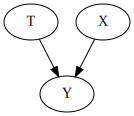

In [38]:
g1 = gr.Digraph()
g1.edge('T', 'Y')
g1.edge('X', 'Y')

g1

### 1.3 Monte Carlo experiment

a. Do not control for any covariates


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1148.11it/s]


N = 100: bias = 0.001561, RMSE = 0.198669
N = 1000: bias = 0.000061, RMSE = 0.064244


b. Control for all the covariates that affect the outcome


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 764.23it/s]


N = 100: bias = 0.007851, RMSE = 0.209319
N = 1000: bias = 0.003886, RMSE = 0.063172


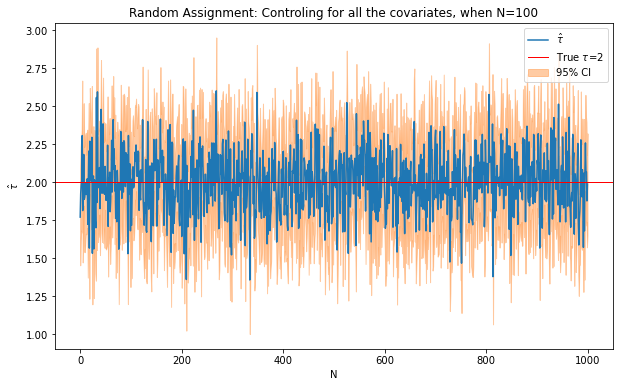

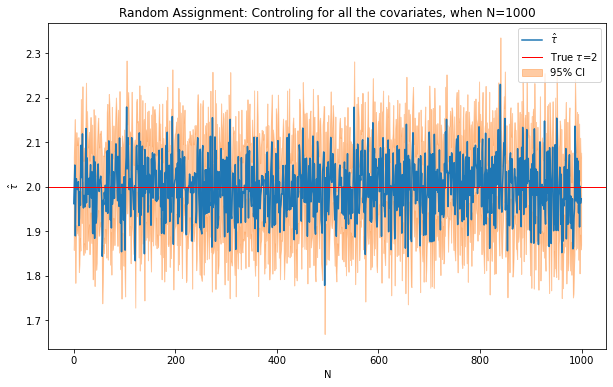

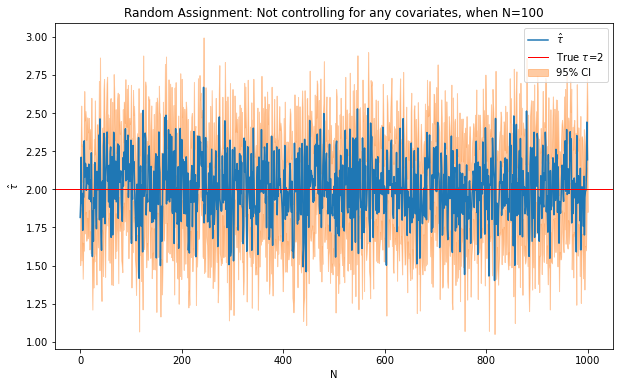

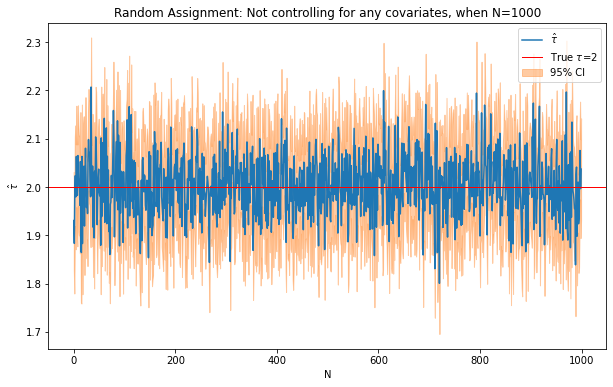

In [61]:
tau = 2
# case_a
print("a. Do not control for any covariates")
monte_carlo_simulation_dgp1(control=False)
print('\n')
# case_b
print("b. Control for all the covariates that affect the outcome")
monte_carlo_simulation_dgp1(control=True)

we can see if we have control the covariates, the bias and RMSE is smaller

### 1.4 Real-life Situation
- Y: Whether a person will go out
- T: Whether a person have something to do
- X: weather

## 2. Simulate a DGP with a confounder

### 2.1  DGP Simulation
assume the following DGP for this section:

$$
Y \equiv \alpha + \tau T + \mathbf{X} \beta_1 + \beta_2 C + e,
$$

where

- $\alpha \equiv 1$ is the intercept,
- $\tau \equiv 2$ is the true treatment effect, i.e., $Y_1 - Y_0 = \tau$ for any observations where $Y_1$ and $Y_0$ are potential outcomes,
- $T$ (treatment) is a $1000 \times 1$ matrix whose element is independent of $\mathbf{X}$ but *not* independent of $C$; specifically, $T$ is given by

$$
T \equiv I \bigg[\frac{\exp(\gamma C_{norm} + \tilde{e})}{1 + \exp(\gamma C_{norm} + \tilde{e})} > p \equiv 0.5 \bigg],
$$

where $I [\cdot]$ is the indicator function, $ \gamma \sim U(0,1)$, $C_{norm}$ is the normalized $C$ (so that it has mean = 0 and std = 1), and $ \tilde{e}$ is a $1000 \times 1$ matrix whose element follows $N(0, 1)$. Since $\gamma > 0$, $T$ and $C$ should be positively related.

- $\mathbf{X}$ (covariates) is a $1000 \times 5$ matrix (i.e., there are 5 covariates) whose row follows a multivariate normal distribution that has a within correlation of 0.5,
- $\beta_1$ (coefficients on covariates) is a $5 \times 1$ matrix whose element follows $N(1, 1)$,
- $\beta_2 \sim N(1, 1)$ (coefficient on confounder),
- $C$ is a $1000 \times 1$ matrix whose element follows a normal distribution, and
- $e$ (disturbance) is a $1000 \times 1$ matrix whose element follows $N(0, 1)$.

In [62]:
def conf_treat(C, p):
    C_scaled = StandardScaler().fit_transform(C)
    nobs, nvar = C_scaled.shape
    gamma = np.random.uniform(0, 1, (nvar, 1))
    e = np.random.normal(0, 1, (nobs, 1))
    p_logit = np.exp(C_scaled*gamma + e)/(1 + np.exp(C_scaled*gamma + e))
    T = (p_logit > p) * 1

    return T
    
def dgp2_data(n=1000, C_control = True):
    tau = 2; alpha = 1; C_flag = 1
    
    X = np.random.normal(0, 1, (n, 5))
    beta1 = np.random.normal(1, 1, (5, 1))
    beta2 = np.random.normal(1, 1)
    C = np.random.normal(0,1,(n, 1))
    e = np.random.normal(0,1,(n, 1))
    T = conf_treat(C, 0.5)
    if not C_control:
        C_flag = 0
        T = np.random.binomial(1, 0.5, (n, 1))
        C = np.zeros((n, 1))
    
    Y = alpha + tau*T + X.dot(beta1) + C_flag*beta2*C + e

    return T, X, Y, C

def dgp2_tauhat(T, X, Y, C, C_control = True):
    intercept = np.ones([T.shape[0], 1])
    covars = np.concatenate([intercept, T, X], axis = 1)
    if C_control:
        covars = np.concatenate([covars, C], axis = 1)
    
    res = sm.OLS(Y, covars).fit()
    tauhat = res.params[1]
    se_tauhat = res.HC1_se[1]
    
    n, p = covars.shape
    dof = n - p

    return tauhat, se_tauhat, dof


def monte_carlo_simulation_dgp2(control):
    for nobs in [100, 1000]:
        tauhats = []; sehats = []
        for r in tqdm(range(monte_num)):
            T, X, Y, C = dgp2_data(nobs, control)
            tauhat, se_tauhat = dgp2_tauhat(T, X, Y, C, control)
            tauhats.append(tauhat)
            sehats.append(se_tauhat)
        
def monte_carlo_simulation_dgp2(control):
    res = {}; tau = 2
    for nobs in [100, 1000]:
        tauhats = []; sehats = []; lb = []; ub = []
        for r in tqdm(range(monte_num)):
            T, X, Y, C = dgp2_data(nobs, control)
            tauhat, se_tauhat, dof = dgp2_tauhat(T, X, Y, C, control)
            tauhats.append(tauhat)
            sehats.append(se_tauhat)
            
            cval = np.abs(t.ppf(q = 0.05, df = dof))

            lb = lb + [tauhat - cval * se_tauhat]
            ub = ub + [tauhat + cval * se_tauhat]
            
        res[nobs] = (tau, tauhats, sehats, lb, ub)
    
    mes = 'Fail to control for the confounder' if control else 'Controling for the confounder'
    for nobs in res:
        tau, tauhats, sehats, lb, ub = res[nobs]
        bias, rmse = fn_bias_rmse_size(tau, tauhats, sehats)    
        print(f'N = {nobs}: bias = {bias:.6f}, RMSE = {rmse:.6f}')
        caption = 'With a Confounder: '+mes+', when N={}'.format(nobs)
        draw_plot(tau, tauhats, sehats, lb, ub, caption)

In [56]:
T, X, Y, C = dgp2_data(1000)
data2 = pd.DataFrame(np.concatenate([Y, T, C, X], axis = 1))
colnames = ['Outcome', 'Treatment', 'Confounder']
for i in range(X.shape[1]):
    colnames += ['Covariate ' + str(i + 1)]
data2.columns = colnames
data2.to_csv("data2.csv", index=False)

### 2.2  DAG Illustration

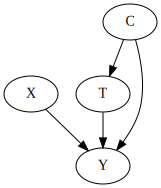

In [15]:
g2 = gr.Digraph()
g2.edge('T', 'Y')
g2.edge('X', 'Y')
g2.edge('C', 'T')
g2.edge('C', 'Y')

g2

### 2.3 Monte Carlo experiment

a. Fail to control for the confounder


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 528.82it/s]


N = 100: bias = -0.001439, RMSE = 0.211108
N = 1000: bias = -0.001915, RMSE = 0.063905


b. Do control for the confounder


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 527.42it/s]


N = 100: bias = -0.003682, RMSE = 0.220411
N = 1000: bias = 0.003650, RMSE = 0.069297


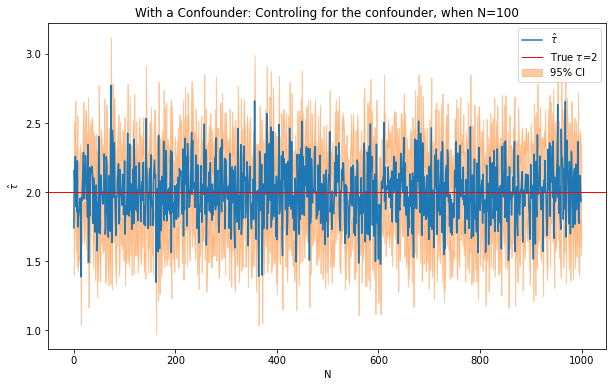

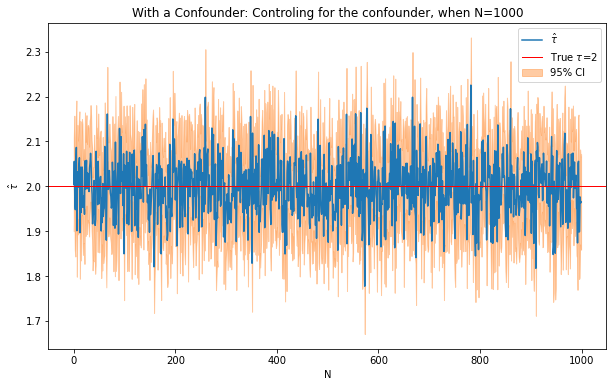

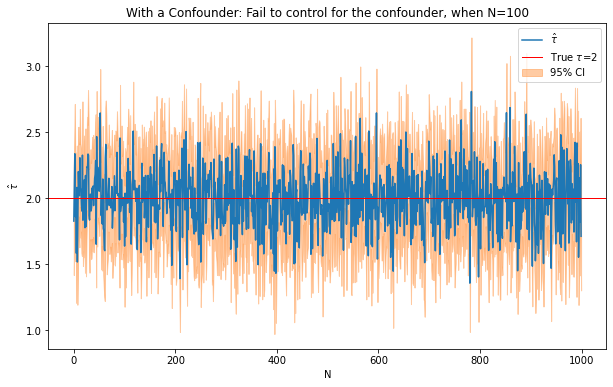

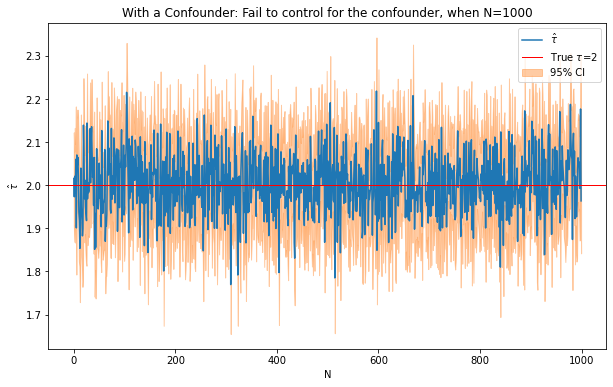

In [63]:
tau = 2
# case_a
print("a. Fail to control for the confounder")
monte_carlo_simulation_dgp2(control=False)
print('\n')
# case_b
print("b. Do control for the confounder")
monte_carlo_simulation_dgp2(control=True)

we also get smaller bias and RMSE in case b

### 2.4 Real-life Situation
- Y: Whether a person can do well in math exam
- T: Whether the person is good at math
- X: Whether the person sleep well before the exam day
- C: The person's IQ

## 3. Simulate a DGP with selection bias into the treatment

### 3.1 DGP Simulation
Assume the following DGP for this section:

$$
Y \equiv \alpha + \frac{\tau}{1 + \delta} T + \frac{\tau}{1 + \delta} S + \mathbf{X} \beta + e,
$$

where

- $\alpha \equiv 1$ is the intercept,
- $\tau \equiv 2$ is the true treatment effect as is shown below,
- $T$ (treatment) is a $1000 \times 1$ matrix whose element is randomly assigned to 1 with proportion $p \equiv 0.5$ or 0 with $1 - p \equiv 0.5$,
- $S$ (selection bias) is a $1000 \times 1$ matrix that **depends on** $T$; specifically,

$$
S \equiv \delta T + \varepsilon,
$$

where $\delta \sim U(0,1)$ and $\varepsilon$ is a $1000 \times 1$ matrix whose element follows $N(0,1)$.

- $\mathbf{X}$ (covariates) is a $1000 \times 5$ matrix (i.e., there are 5 covariates) whose row follows a multivariate normal distribution that has a within correlation of 0.5,
- $\beta$ (coefficients on covariates) is a $5 \times 1$ matrix whose element follows $N(1, 1)$, and
- $e$ (disturbance) is a $1000 \times 1$ matrix whose element follows $N(0, 1)$.


In [64]:
def dgp3_data(n=1000, S_control = True):
    tau = 2; alpha = 1; S_flag = 1
    if not S_control:
        S_flag = 0
    
    T = np.random.binomial(1, 0.5, (n, 1))   
    X = np.random.normal(0, 1, (n, 5))
    epsilon = np.random.normal(0, 1, (n, 1))
    delta = np.random.uniform (0, 1) * S_flag
    S = delta*T + epsilon
    beta = np.random.normal(1, 1, (5, 1))
    e = np.random.normal(0,1,(n, 1))
    
    Y = alpha + tau*T/(1+delta) + S_flag*tau*S/(1+delta) + X.dot(beta) + e

    return T, X, Y, S

def dgp3_tauhat(T, X, Y, S, S_control = True):
    intercept = np.ones([T.shape[0], 1])
    covars = np.concatenate([intercept, T, X], axis = 1)
    if S_control:
        covars = np.concatenate([covars, S], axis = 1)
    
    res = sm.OLS(Y, covars).fit()
    tauhat = res.params[1]
    se_tauhat = res.HC1_se[1]
    
    n, p = covars.shape
    dof = n - p

    return tauhat, se_tauhat, dof


def monte_carlo_simulation_dgp3(control):
    res = {}; tau = 2
    for nobs in [100, 1000]:
        tauhats = []; sehats = []; lb = []; ub = []
        for r in tqdm(range(monte_num)):
            T, X, Y, S = dgp3_data(nobs, control)
            tauhat, se_tauhat, dof = dgp3_tauhat(T, X, Y, S, control)
            tauhats.append(tauhat)
            sehats.append(se_tauhat)
            
            cval = np.abs(t.ppf(q = 0.05, df = dof))

            lb = lb + [tauhat - cval * se_tauhat]
            ub = ub + [tauhat + cval * se_tauhat]
            
        res[nobs] = (tau, tauhats, sehats, lb, ub)
    
    mes = 'Controling for the selection bias' if control else 'Not controling for the selection bias'
    for nobs in res:
        tau, tauhats, sehats, lb, ub = res[nobs]
        bias, rmse = fn_bias_rmse_size(tau, tauhats, sehats)    
        print(f'N = {nobs}: bias = {bias:.6f}, RMSE = {rmse:.6f}')
        caption = 'With a Selection Bias: '+mes+', when N={}'.format(nobs)
        draw_plot(tau, tauhats, sehats, lb, ub, caption)

In [18]:
# generate data
T, X, Y, S = dgp3_data(1000)
data3 = pd.DataFrame(np.concatenate([Y, T, S, X], axis = 1))
colnames = ['Outcome', 'Treatment', 'Selection']
for i in range(X.shape[1]):
    colnames += ['Covariate ' + str(i + 1)]
data3.columns = colnames
data3.to_csv("data3.csv", index=False)

### 3.2  DAG Illustration

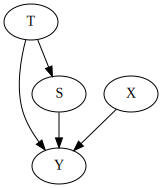

In [19]:
g3 = gr.Digraph()
g3.edge('T', 'Y')
g3.edge('T', 'S')
g3.edge('S', 'Y')
g3.edge('X', 'Y')

g3

### 3.3 Monte Carlo experiment

a. Controling for the selection bias


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 609.38it/s]


N = 100: bias = -0.613136, RMSE = 0.698792
N = 1000: bias = -0.612897, RMSE = 0.674711


b. Not controling for the selection bias


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 717.36it/s]


N = 100: bias = -0.008164, RMSE = 0.200600
N = 1000: bias = -0.001408, RMSE = 0.060562


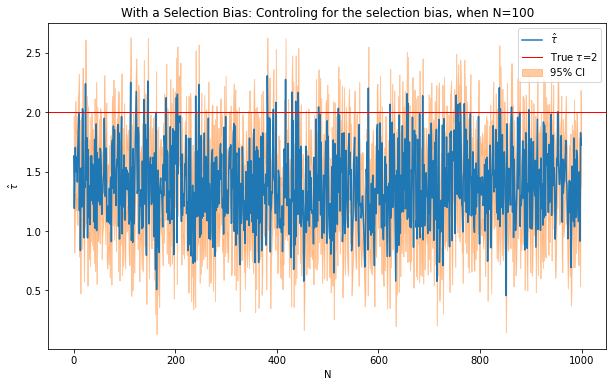

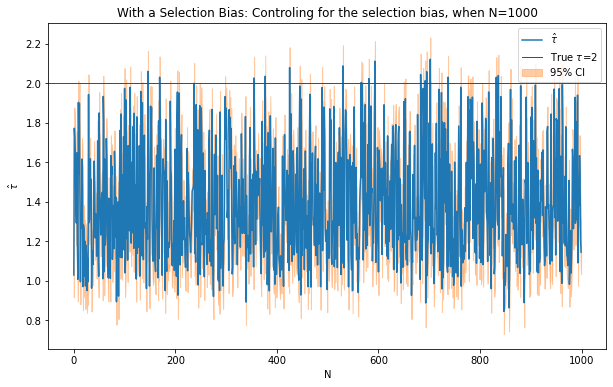

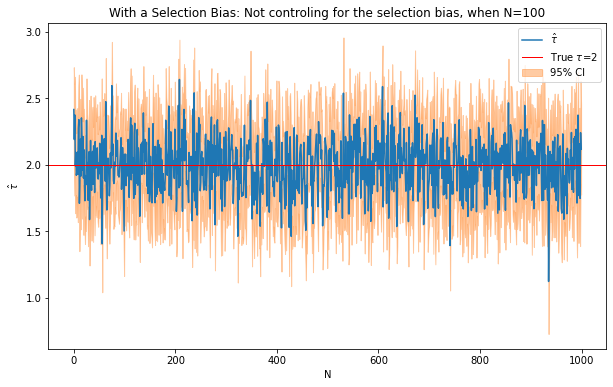

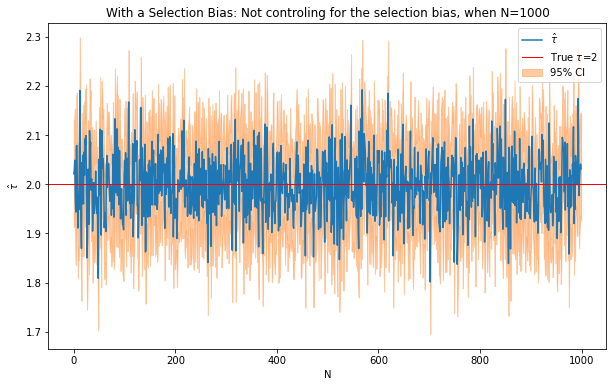

In [66]:
tau = 2
# case_a
print("a. Controling for the selection bias")
monte_carlo_simulation_dgp3(control=True)
print('\n')
# case_b
print("b. Not controling for the selection bias")
monte_carlo_simulation_dgp3(control=False)

In case a, if we control the variable, we will get bigger bias and RMSE than case b

### 3.4 Real-life Situation
- Y: Get a high salary
- T: Valued by the boss
- X: Get along with colleague
- S: Finished important taskes